In [1]:
import numpy as np
import sncosmo
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import matplotlib.pyplot as plt
from tdastro.obstable.opsim import OpSim

In [2]:
# ==============================================================================
# Configuration
# ==============================================================================
N_OBJECTS_PER_CLASS = 5  # Number of light curves to generate for each class
OPSIM_DB_PATH = "/Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/opsim/baseline_v5.0.0_10yrs.db"  # Path to your downloaded OpSim database
LSST_BANDS = ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz']
DENSE_LC_NOISE_LEVEL = 0.01 # Add a small amount of noise to the dense LC fluxes, relative to peak flux

In [3]:
# Use a standard cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
# ==============================================================================
# Part 1: Model and Parameter Setup
# ==============================================================================

# Define the models we want to use for different supernova classes
# We use SALT2 for Type Ia and Nugent's templates for others.
SN_MODELS = {
    'SNIa': sncosmo.Model(source='salt2'),
    'SNIbc': sncosmo.Model(source='nugent-sn1bc'),
    'SNII': sncosmo.Model(source='nugent-sn2p')
}

def sample_snia_params(t_min, t_max):
    """Samples realistic parameters for a Type Ia supernova (SALT2 model)."""
    # Redshift
    z = np.random.uniform(0.05, 1.0)
    
    # Time of peak brightness
    t0 = np.random.uniform(t_min + 30, t_max - 70)
    
    # SALT2 shape and color parameters
    x1 = np.random.normal(0., 1.)
    c = np.random.normal(0., 0.1)
    
    # Amplitude (x0) is derived from redshift and an absolute magnitude distribution
    # A brighter SN (lower M_B) will have a larger x0
    m_b = np.random.normal(-19.3, 0.3)
    dist_mod = cosmo.distmod(z).value
    m_abs = m_b - (dist_mod)
    x0 = 10**(-0.4 * (m_abs - 25.)) # A rough conversion to x0
    
    return {'z': z, 't0': t0, 'x1': x1, 'c': c, 'x0': x0}

def sample_core_collapse_params(t_min, t_max):
    """Samples parameters for core-collapse SNe (template-based models)."""
    # Redshift
    z = np.random.uniform(0.05, 0.5) # Core-collapse are typically observed at lower z
    
    # Time of peak brightness
    t0 = np.random.uniform(t_min + 30, t_max - 70)
    
    # Amplitude is a simple scaling factor for the template
    # We'll tie it to redshift to make fainter SNe at higher z
    dist_mod = cosmo.distmod(z).value
    amplitude = 10**(-0.4 * (dist_mod - 35)) # Heuristic scaling
    
    return {'z': z, 't0': t0, 'amplitude': amplitude}

# Map each model type to its parameter sampling function
PARAM_SAMPLERS = {
    'SNIa': sample_snia_params,
    'SNIbc': sample_core_collapse_params,
    'SNII': sample_core_collapse_params,
}

In [8]:
opsim_db

In [10]:
t_max

np.float64(64632.272916088485)

In [38]:
from tdastro.simulate import simulate_lightcurves
from tdastro.astro_utils.passbands import PassbandGroup
passband_group = PassbandGroup.from_preset(preset="LSST")


2025-09-09 00:12:13,606 - INFO - Loading passbands from preset LSST
2025-09-09 00:12:13,608 - INFO - Data file /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/u.dat already exists. Skipping download.
2025-09-09 00:12:13,611 - INFO - Loading passband from file: /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/u.dat
2025-09-09 00:12:13,632 - INFO - Data file /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/g.dat already exists. Skipping download.
2025-09-09 00:12:13,633 - INFO - Loading passband from file: /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/g.dat
2025-09-09 00:12:13,644 - INFO - Data file /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/r.dat already exists. Skipping download.
2025-09-09 00:12:13,645 - INFO - Loading passband from file: /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/r.dat
2025-09-09 00:12:13,651

In [40]:

lightcurves = simulate_lightcurves(
    model,  # The model to simulate (including effects).
    1,  # The number of light curves to simulate.
    opsim_db,  # The survey information.
    passband_group,  # The passband information.
)
print(lightcurves)


AttributeError: 'Model' object has no attribute 'sample_parameters'

Filter u: 4.70 * sin(t + 7.94) + 23.12
Filter g: 2.39 * sin(t + 5.44) + 17.31
Filter r: 4.81 * sin(t + 2.83) + 24.55
Filter i: 3.98 * sin(t + 7.46) + 17.04
Filter z: 1.98 * sin(t + 4.48) + 22.92
Filter y: 4.41 * sin(t + 8.15) + 20.71


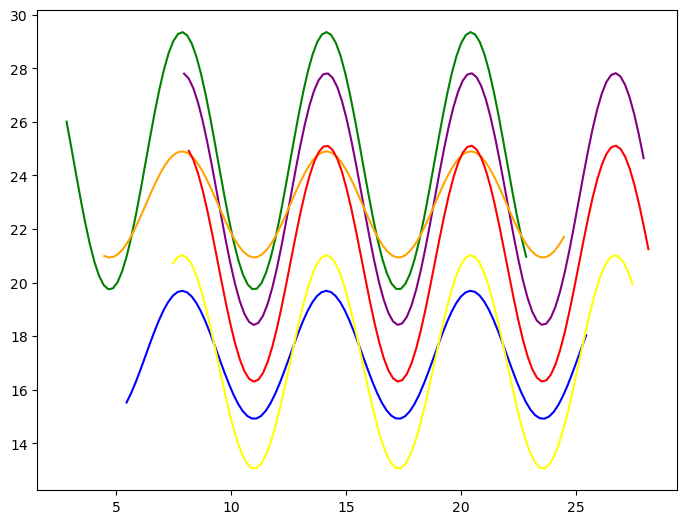

In [51]:
from tdastro.consts import lsst_filter_plot_colors
num_times = 100
times = np.linspace(0, 20, num_times)
filters = passband_group.filters

lightcurves = {}
for filter in filters:
    amp = 5.0 * np.random.random() + 1.0
    flux_offset = np.random.random() * 25 + 10
    time_offset = np.random.random() * 10
    filter_flux = amp * np.sin(times + time_offset) + flux_offset
    print(f"Filter {filter}: {amp:.2f} * sin(t + {time_offset:.2f}) + {flux_offset:.2f}")

    lightcurves[filter] = np.array([times + time_offset, filter_flux]).T
# Plot the light curves
figure = plt.figure()
ax = figure.add_axes([0, 0, 1, 1])
for filter, lightcurve in lightcurves.items():
    color = lsst_filter_plot_colors.get(filter, "black")
    ax.plot(lightcurve[:, 0], lightcurve[:, 1], color=color, label=filter)

In [53]:
from tdastro.models.lightcurve_template_model import (
    LightcurveData,
    LightcurveTemplateModel,
    MultiLightcurveTemplateModel,
)
model = LightcurveTemplateModel(lightcurves, passband_group, t0=0.0)

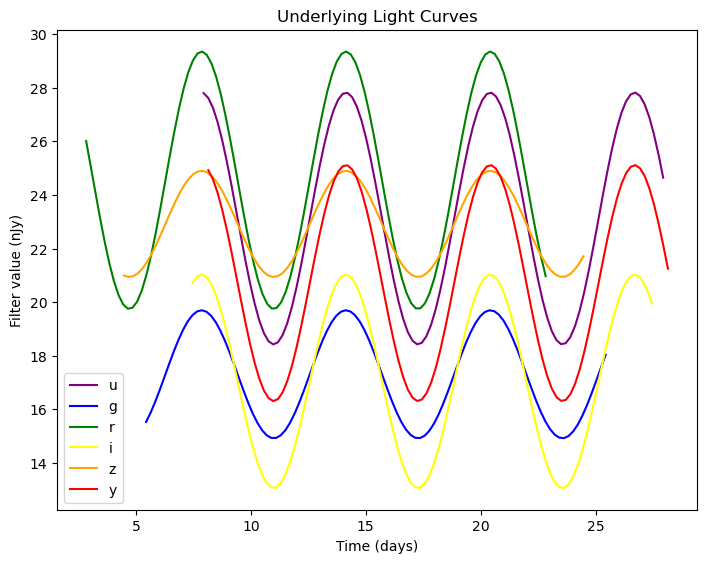

In [54]:
model.plot_lightcurves()


In [6]:
from tqdm.auto import tqdm

# ==============================================================================
# Part 2: Generating the Datasets
# ==============================================================================
print("Loading OpSim database... (This might take a moment)")
opsim_db = OpSim.from_db(OPSIM_DB_PATH)
t_min, t_max = opsim_db.time_bounds()
print(f"Database loaded. Survey time range: [{t_min:.2f}, {t_max:.2f}] MJD")


dense_light_curves = []
sparse_light_curves = []

for sn_class, model in SN_MODELS.items():
    print(f"\nGenerating {N_OBJECTS_PER_CLASS} light curves for class: {sn_class}")
    
    for i in range(N_OBJECTS_PER_CLASS):
        # --- 1. Sample Parameters ---
        params = PARAM_SAMPLERS[sn_class](t_min, t_max)
        model.set(**params)
        
        # Also sample a random sky location for this object
        ra = np.random.uniform(0, 360)
        dec = np.random.uniform(-60, 0)

        # Store metadata
        metadata = {
            'sn_class': sn_class,
            'ra': ra,
            'dec': dec,
            **params
        }

        # --- 2. Generate Dense "Hidden" Light Curve ---
        t_dense = np.arange(params['t0'] - 30, params['t0'] + 70, 0.5)

        # <<<<<<<<<<<<<<<<<<<<<<<< FIX IS HERE <<<<<<<<<<<<<<<<<<<<<<<<
        # Calculate fluxes for each band separately by looping, which is clearer
        # and avoids the broadcasting/hashing issue inside sncosmo.
        flux_list = []
        for band in LSST_BANDS:
            # `model.bandflux` works correctly with a single band (string)
            # and a 1D array of times.
            flux = model.bandflux(band, t_dense, zp=27.5, zpsys='ab')
            flux_list.append(flux)

        # Stack the list of 1D flux arrays into a single (n_times, n_bands) array.
        # The list of arrays has shape (6, 200), so we transpose it.
        flux_dense = np.array(flux_list).T
        
        # Add a small amount of noise to the dense light curve
        fluxerr_dense = np.zeros_like(flux_dense)
        for j, band in enumerate(LSST_BANDS):
            peak_flux = np.max(flux_dense[:, j])
            noise = np.random.normal(0., DENSE_LC_NOISE_LEVEL * peak_flux, size=len(t_dense))
            flux_dense[:, j] += noise
            fluxerr_dense[:, j] = DENSE_LC_NOISE_LEVEL * peak_flux

        # Format into an Astropy Table
        dense_lc_rows = []
        for j, band in enumerate(LSST_BANDS):
            for k in range(len(t_dense)):
                dense_lc_rows.append((t_dense[k], band, flux_dense[k, j], fluxerr_dense[k, j], 27.5, 'ab'))
        
        dense_lc = Table(rows=dense_lc_rows, names=('time', 'band', 'flux', 'fluxerr', 'zp', 'zpsys'))
        dense_lc.meta = metadata
        dense_light_curves.append(dense_lc)

        # --- 3. Generate Sparse "LSST-like" Light Curve ---
        # Get the actual LSST observation schedule for this location
        # The radius defines the search cone on the sky.
        obs_schedule = opsim_db.get_observations(query_ra=ra, query_dec=dec, radius=1.75 * u.deg)
        
        # Use sncosmo to realize the light curve based on the schedule
        # This function handles noise based on the sky conditions in the OpSim database
        sparse_lc = sncosmo.realize_lcs(obs_schedule, model, [params], scatter=False)[0]
        sparse_lc.meta = metadata
        sparse_light_curves.append(sparse_lc)
        
        print(f"  Generated object {i+1}/{N_OBJECTS_PER_CLASS} "
              f"-> Dense LC: {len(dense_lc)} points, Sparse LC: {len(sparse_lc)} points")


print(f"\nGeneration complete.")
print(f"Total dense light curves: {len(dense_light_curves)}")
print(f"Total sparse light curves: {len(sparse_light_curves)}")

Loading OpSim database... (This might take a moment)
Database loaded. Survey time range: [60980.00, 64632.27] MJD

Generating 5 light curves for class: SNIa


ValueError: observations not understood

In [ ]:
    Table of observations. Must contain the following column names:
    ``band``, ``time``, ``zp``, ``zpsys``, ``gain``, ``skynoise``.


In [14]:
obs_schedule.keys()

dict_keys(['observationId', 'ra', 'dec', 'time', 'flush_by_mjd', 'exptime', 'band', 'filter', 'rotSkyPos', 'rotSkyPos_desired', 'nexposure', 'airmass', 'seeingFwhm500', 'seeing', 'seeingFwhmGeom', 'skybrightness', 'night', 'slewTime', 'visitTime', 'slewDistance', 'fiveSigmaDepth', 'altitude', 'azimuth', 'paraAngle', 'pseudoParaAngle', 'cloud', 'moonAlt', 'sunAlt', 'scheduler_note', 'target_name', 'target_id', 'observationStartLST', 'rotTelPos', 'rotTelPos_backup', 'moonAz', 'sunAz', 'sunRA', 'sunDec', 'moonRA', 'moonDec', 'moonDistance', 'solarElong', 'moonPhase', 'cummTelAz', 'observation_reason', 'science_program', 'cloud_extinction', 'zp'])

In [12]:
sncosmo.realize_lcs(obs_schedule, model, [params], scatter=False)

ValueError: observations not understood

In [8]:
opsim_db._table

,observationId,ra,dec,time,flush_by_mjd,exptime,band,filter,rotSkyPos,rotSkyPos_desired,...,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,observation_reason,science_program,cloud_extinction,zp
0,0,261.567911,-27.431786,60980.001626,60980.02490,15.0,r,r,336.671299,0.0,...,338.750941,-9.612033,74.272993,44.199760,65.730372,-105.779024,pairs_i_5.0,None,0.0,1.217599
1,1,262.851107,-22.591159,60980.001877,60980.02490,15.0,r,r,339.138048,0.0,...,338.752735,-9.610496,73.388864,44.943838,65.731465,-100.078820,pairs_i_5.0,None,0.0,1.226834
2,2,261.834513,-19.886311,60980.002123,60980.02490,15.0,r,r,340.673287,0.0,...,338.754493,-9.608989,74.537327,43.949916,65.732536,-97.689502,pairs_i_5.0,None,0.0,1.245444
3,3,260.885516,-17.164857,60980.002369,60980.02490,15.0,r,r,342.034908,0.0,...,338.756252,-9.607481,75.688202,43.121464,65.733607,-95.361047,pairs_i_5.0,None,0.0,1.267681
4,4,262.197819,-12.138795,60980.002619,60980.02490,15.0,r,r,344.082520,0.0,...,338.758043,-9.605944,74.981544,44.870040,65.734698,-89.776300,pairs_i_5.0,None,0.0,1.282963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048607,2048607,70.400259,-72.260546,64632.270857,64632.32233,38.0,u,u,296.294115,0.0,...,230.594882,-12.729282,93.999795,90.518505,8.039063,-174.093535,pairs_ug_33.0,None,0.0,2.717320
2048608,2048608,60.692490,-76.403093,64632.271382,64632.32233,38.0,u,u,308.438959,0.0,...,230.603893,-12.730985,90.662758,88.158308,8.043509,-170.539405,pairs_ug_33.0,None,0.0,2.834127
2048609,2048609,71.299640,-75.257240,64632.271893,64632.32233,38.0,u,u,295.879323,0.0,...,230.612663,-12.732644,91.092793,87.889337,8.047836,-174.114775,pairs_ug_33.0,None,0.0,2.797272
2048610,2048610,83.460458,-76.500274,64632.272404,64632.32233,38.0,u,u,281.740836,0.0,...,230.621436,-12.734306,88.680469,85.034698,8.052163,-177.805729,pairs_ug_33.0,None,0.0,2.853077


In [ ]:
# ==============================================================================
# Part 3: Inspecting and Visualizing the Output
# ==============================================================================

# Print the first sparse light curve as an example
print("\n--- Example Sparse Light Curve (first object) ---")
print(sparse_light_curves[0])
print("\nMetadata:")
print(sparse_light_curves[0].meta)


def plot_lc_pair(dense_lc, sparse_lc, obj_index=0):
    """A simple function to visualize a pair of dense/sparse light curves."""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    meta = dense_lc.meta
    title = f"Object {obj_index}: {meta['sn_class']} at z={meta['z']:.2f}"
    
    for band in LSST_BANDS:
        # Plot dense data
        dense_band_data = dense_lc[dense_lc['band'] == band]
        ax.plot(dense_band_data['time'], dense_band_data['flux'], '-', alpha=0.5,
                label=f'{band} (dense)')
        
        # Plot sparse data
        sparse_band_data = sparse_lc[sparse_lc['band'] == band]
        ax.errorbar(sparse_band_data['time'], sparse_band_data['flux'], 
                    yerr=sparse_band_data['fluxerr'],
                    fmt='o', label=f'{band} (sparse)')

    ax.set_xlabel("Time (MJD)")
    ax.set_ylabel("Flux (zp=27.5, AB)")
    ax.set_title(title)
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize the first generated pair
print("\nPlotting the first generated (dense, sparse) light curve pair...")
plot_lc_pair(dense_light_curves[0], sparse_light_curves[0], obj_index=0)